# Anitápolis TFA multiple Inversions

This notebook performs the inversion using Levenberg-Marquadt's algorithm of total field anomaly (TFA).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando.vis import mpl

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
from datetime import date
today = date.today()
# dd/mm/YY
d4 = today.strftime("%b-%d-%Y")

### Auxiliary functions

In [3]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing Diorama TFA data

In [4]:
data = pd.read_csv('diorama_decimated_tfa_residual.txt', skipinitialspace=True, delim_whitespace=True)

In [5]:
data['GPSALT'] = 430 - data['GPSALT']

In [6]:
xp = data['X'].get_values()
yp = data['Y'].get_values()
zp = data['GPSALT'].get_values()
dobs = data['mag_res2'].get_values()

In [7]:
np.max(zp)

767.79

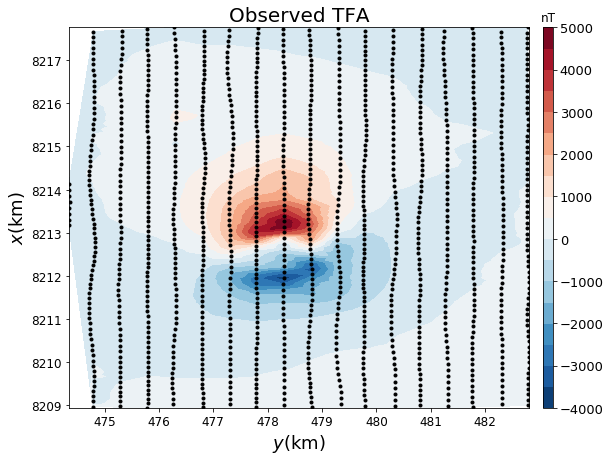

In [8]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.plot(yp, xp, 'k.')
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.show()

### Parameters of the initial model

In [9]:
#initial estimate
M = 20 # number of vertices per prism
L = 6 # number of prisms
P = L*(M+2) + 1 # number of parameters

#figura
incs = -46.
decs = 24.
intensity = 16.
z0 = 50.

# depth to the top, thickness and radius
dz_min = 100.
dz_max = 550.
dz = np.linspace(dz_min, dz_max, 10)

r0_min = 200.
r0_max = 2000.
r0 = np.linspace(r0_min, r0_max, 10)

x0, y0 = [8212500., 478200.]

# main field
inc = -19.5
dec = -18.

In [10]:
r0

array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
       2000.])

In [11]:
dz

array([100., 150., 200., 250., 300., 350., 400., 450., 500., 550.])

### Limits

In [12]:
# limits for parameters in meters
rmin = 10.
rmax = 2000.
x0min = 8212500.
x0max = 8213500.
y0min = 478000.
y0max = 479000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [13]:
# variation for derivatives
deltax = 0.01*np.max(100.)
deltay = 0.01*np.max(100.)
deltar = 0.01*np.max(100.)
deltaz = 0.01*np.max(100.)

### Outcropping parameters

In [14]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

### Regularization parameters

In [15]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-4   # adjacent radial distances within each prism
a2 = 1.0e-3   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-5    # vertically adjacent origins
a6 = 1.0e-7   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-5     # zero order Tikhonov on thickness of each prism

In [16]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [17]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

### Inversion

In [18]:
inversion_results = []
for j, z in enumerate(dz):
    for k, r in enumerate(r0):
        alpha = np.array([a1, a2, a3, a4, a5, a6, a7])
        print 'inversion: %d  thickness: %d  radius: %2.f' % (j*dz.size + k, z, r)
        model0, m0 = mfun.initial_cylinder(M, L, x0, y0, z0, z, r, inc, dec, incs, decs, intensity)
        d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.l1_levmarq_tf(
            xp, yp, zp, m0, M, L, delta,
            itmax, itmax_marq, lamb,
            dlamb, tol, mmin, mmax,
            m_out, dobs, inc, dec,
            model0[0].props, alpha, z0, z
        )
        inversion_results.append([m_est, phi_list, model_list, dobs - d_fit])

inversion: 0  thickness: 100  radius: 200
it:  0   it_marq:  0   lambda: 1e+01   init obj.: 2.22987e+06  fin obj.: 3.94547e+06
it:  0   it_marq:  1   lambda: 1e+02   init obj.: 2.22987e+06  fin obj.: 7.30175e+06
it:  0   it_marq:  2   lambda: 1e+03   init obj.: 2.22987e+06  fin obj.: 7.43405e+06
it:  0   it_marq:  3   lambda: 1e+04   init obj.: 2.22987e+06  fin obj.: 7.42547e+06
it:  0   it_marq:  4   lambda: 1e+05   init obj.: 2.22987e+06  fin obj.: 7.42546e+06
it:  0   it_marq:  5   lambda: 1e+06   init obj.: 2.22987e+06  fin obj.: 5.76099e+06
it:  0   it_marq:  6   lambda: 1e+07   init obj.: 2.22987e+06  fin obj.: 5.76079e+06
it:  0   it_marq:  7   lambda: 1e+08   init obj.: 2.22987e+06  fin obj.: 5.76112e+06
it:  0   it_marq:  8   lambda: 1e+09   init obj.: 2.22987e+06  fin obj.: 5.76177e+06
it:  0   it_marq:  9   lambda: 1e+10   init obj.: 2.22987e+06  fin obj.: 2.41143e+06
it:  1   it_marq:  0   lambda: 1e+11   init obj.: 2.22987e+06  fin obj.: 2.41145e+06
it:  1   it_marq:  1   

../../code/mag_polyprism_functions.py:1621: RuntimeWarning: divide by zero encountered in log
  mt = - np.log((mmax - m)/(m - mmin + 1e-2))


it:  0   it_marq:  0   lambda: 1e+01   init obj.: 8.61050e+06  fin obj.: 6.42665e+07
it:  0   it_marq:  1   lambda: 1e+02   init obj.: 8.61050e+06  fin obj.: 6.42294e+07
it:  0   it_marq:  2   lambda: 1e+03   init obj.: 8.61050e+06  fin obj.: 1.22389e+08
it:  0   it_marq:  3   lambda: 1e+04   init obj.: 8.61050e+06  fin obj.: 8.39765e+07
it:  0   it_marq:  4   lambda: 1e+05   init obj.: 8.61050e+06  fin obj.: 8.39765e+07
it:  0   it_marq:  5   lambda: 1e+06   init obj.: 8.61050e+06  fin obj.: 8.39765e+07
it:  0   it_marq:  6   lambda: 1e+07   init obj.: 8.61050e+06  fin obj.: 1.22175e+08
it:  0   it_marq:  7   lambda: 1e+08   init obj.: 8.61050e+06  fin obj.: 6.41897e+07
it:  0   it_marq:  8   lambda: 1e+09   init obj.: 8.61050e+06  fin obj.: 6.41897e+07
it:  0   it_marq:  9   lambda: 1e+10   init obj.: 8.61050e+06  fin obj.: 2.59870e+07
it:  1   it_marq:  0   lambda: 1e+11   init obj.: 8.61050e+06  fin obj.: 2.59869e+07
it:  1   it_marq:  1   lambda: 1e+12   init obj.: 8.61050e+06  fi

### Folder to save the results

In [19]:
mypath = 'L1_tfa_inversion/multiple_r0_min%d_r0_max%d_dz_min%d_dz_max%d_int%d_z0%d_V%d_L%d' % (r0_min, r0_max, dz_min, dz_max, intensity, z0, M, L)
mypath += d4
if not os.path.isdir(mypath):
   os.makedirs(mypath)

In [20]:
mypath

'L1_tfa_inversion/multiple_r0_min200_r0_max2000_dz_min100_dz_max550_int16_z050_V20_L6Jul-03-2020'

# Results

In [21]:
inversion = dict()

In [22]:
inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs

In [23]:
inversion['x'].size

1230

In [24]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['dz'] = dz
inversion['r0'] = r0
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = np.array([a1, a2, a3, a4, a5, a6, a7])
inversion['tol'] = tol
inversion['main_field'] = [inc, dec]
inversion['intensity'] = intensity

In [25]:
inversion['results'] = inversion_results

In [26]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)

In [27]:
mypath

'L1_tfa_inversion/multiple_r0_min200_r0_max2000_dz_min100_dz_max550_int16_z050_V20_L6Jul-03-2020'

###### 